# Basics of Sakkara examplified by linear mixed models
In this notebook, we will introduce the basics of Sakkara examplified with an implementation of mixed linear model on some toy data.

## Idea of Sakkara
Sakkara is a framework based on top of [PyMC](https://www.pymc.io/) that intends to simplify the coding of complex Bayesian models, with hierarchies and fusion of different information sources.

## Data set
First, we generate the toy data:

In [1]:
import numpy as np
import pandas as pd

N = 40
df = pd.DataFrame({'supergroup': np.repeat(['a', 'a', 'b', 'b'], N),
                   'slope': np.repeat([-1, -1, 1, 1], N),
                   'subgroup': np.repeat(['q', 'r', 's', 't'], N),
                   'intercept': np.repeat([5, 3, -3, -5], N),
                   'x': np.random.default_rng(100).normal(0, 1, 4 * N)
                  })

df['y'] = df['x'] * df['slope'] + df['intercept'] + np.random.default_rng(1).normal(0, 1, 4 * N)

In this dataframe, there are four different *subgroups*, each one corresponding to a particular intercept value. There are also two *supergroups*, each one corresponding to a particular slope value. Note that given a subgroup, we also know the supergroup. Also note that intercept values of subgroups within the same supergroup are more similar to each other than with the other subgroups' intercept values.

We will consider the regression problem of predicting y given x, but with only access to a sample of all data. The sub- and supergroups are not represented by equally sized proportions in this sample, instead they are varying from 1 to 20 samples per subgroup. 

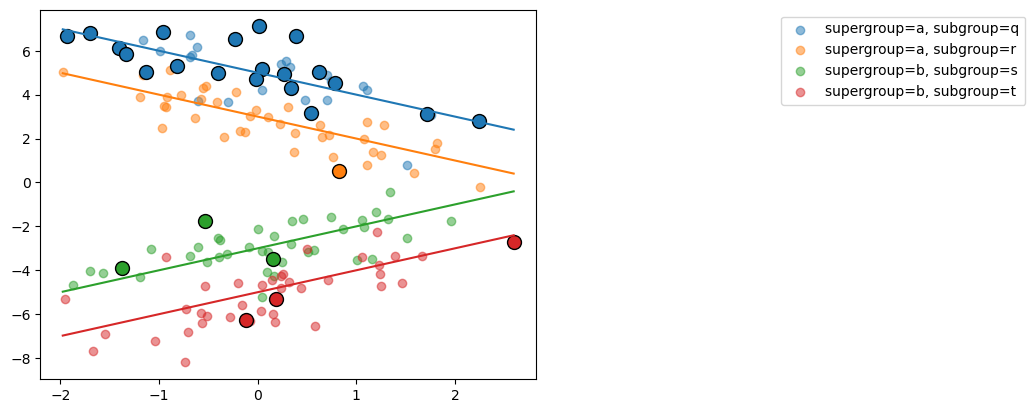

In [2]:
import matplotlib.pyplot as plt

sampling = {'q': {'n': 20, 'seed': 1}, 'r': {'n': 1, 'seed': 18}, 's': {'n': 3, 'seed': 19}, 't': {'n': 3, 'seed': 3}}
sample_df = pd.concat([df.loc[df['subgroup'] == k].sample(n=v['n'], random_state=v['seed']) for k, v in sampling.items()])
sample_df = sample_df.reset_index(drop=True)

for k, g in df.groupby('subgroup'):
    label = 'supergroup=' + g['supergroup'].iloc[0] + ', subgroup=' + g['subgroup'].iloc[0]
    plt.scatter(g['x'], g['y'], label=label, alpha=.5)
    
    intercept = g['intercept'].iloc[0]
    slope = g['slope'].iloc[0]
    plt.plot([df['x'].min(), df['x'].max()], [df['x'].min() * slope + intercept, df['x'].max()* slope + intercept])
plt.gca().set_prop_cycle(None)
for k, g in sample_df.groupby('subgroup'):
    plt.scatter(g['x'], g['y'], s=100, linewidths=1, edgecolors='k')
plt.legend(bbox_to_anchor=(2,1))
plt.show()

In [3]:
sample_df

,supergroup,slope,subgroup,intercept,x,y
0,a,-1,q,5,0.780854,4.549583
1,a,-1,q,5,-1.127178,5.015157
2,a,-1,q,5,0.543974,3.152869
3,a,-1,q,5,-1.405471,6.129868
4,a,-1,q,5,-0.406249,4.984059
5,a,-1,q,5,0.039840,5.177482
6,a,-1,q,5,-0.231096,6.525159
7,a,-1,q,5,-1.704170,6.813184
8,a,-1,q,5,-1.931101,6.673909
9,a,-1,q,5,1.713684,3.111543


## Modeling

Clearly, a model with complete pooling, i.e., treating all samples equally irrespective to the different groups, will not produce sensible results. In other words, there is a need for group pooling of variables and observations, which is a fundamental feature of Sakkara. We will consider three different models, each one with increasing complexity, and compare their performance in the end of this notebook.

In [4]:
idatas = []

We have the set of subgroups $U=\{q, r, s, t\}$ and the set of supergroups $V=\{a, b\}$. The supergroup of a subgroup can be retrieved by $f: U \rightarrow V$, such that

$$
f(u) =
\begin{cases}
a \text{ if } u = q \text{ or } u = r\\
b \text{ if } u = s \text{ or } u = t\\
\end{cases}.
$$

Moreover, we have the data set of $N$ inputs, consisting of the input data vector $\mathbf{x} \in \mathbb{R}^N$, the response variable $\mathbf{y} \in \mathbb{R}^N$, and the vector of subgroups for each observation $\mathbf{s} \in U^N$.

### Model 1: independent variables per subgroup
The first model we consider is by having variables that are unique and indepedent for each subgroup:

$$
\alpha_u \sim \mathcal{N}(0,10) \quad \forall \, u \in U\\
\beta_u \sim \mathcal{N}(0,10) \quad \forall \, u \in U\\
\hat{y_i} = \alpha_{s_i} + x_i \cdot \beta_{s_i} \text{ for } i \in 1, \ldots, N \\
y_{i} \mid \alpha_{s_i}, \beta_{s_i} \sim \mathcal{N}(\hat{y}, 1) \text{ for } i \in 1, \ldots, N \\
$$

To create a PyMC model using Sakkara, we need at least one **component** for each PyMC variable object. Metaphorically, a component in Sakkara is the glue between PyMC variables and relational information from the dataframe.

The most fundamental component is the `DistributionComponent`, which is used to create variables from [any distribution that is implemented in PyMC](https://www.pymc.io/projects/docs/en/stable/api/distributions.html). In the examples of this notebook, only [the normal distribution](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Normal.html). To create a component for the slope variable, we do

In [5]:
import pymc as pm
from sakkara.model import DistributionComponent as DC

alpha = DC(pm.Normal, name='alpha', group='subgroup', mu=0, sigma=10)

. The first argument, `pm.Normal`, is always required for DistributionComponent and it should be a reference to the constructor of the correponding distribution class in PyMC.

The `name` argument will be passed as `name` to the constructor we passed as the first argument. `name` is not always required, as we will see later on in this notebook.

The `group` argument, which is optional, defines the relational context for which the variable will be created. The value of this argument must correspond to the name of a column found in the dataframe, or a tuple of column names. In this case, since we specify `group='subgroup'` and there are four unique subgroup values in the dataframe column, the PyMC resulting variable created from this component will be 4-dimensional.  

The remaining arguments, `mu` and `sigma`, correspond to arguments that will be passed to `pm.Normal`. However, in this case the specified values correspond to the default values, and we do not need to specify them explictly. Therefore, we can create the `beta` component by

In [6]:
beta = DC(pm.Normal, name='beta', group='subgroup', sigma=10)

. In Sakkara, we also need to create specific components for the data. This is easily performed with

In [7]:
from sakkara.model import data_components

data = data_components(sample_df)

, which creates a dictionary of one component per column in the dataframe. Hence, to access column 'x', we do `data['x']`. 

Lastly, we have to specify components corresponding to $\hat{\mathbf{y}}$ and the likelihood:

In [8]:
from sakkara.model import Likelihood

y_hat = alpha + beta * data['x']

likelihood = Likelihood(pm.Normal, mu=y_hat, sigma=1, observed=data['y'])

We can perform mathematical operations on the components, so that `y_hat` will be a new component relying on the previously defined ones. When creating the model, we do **not** have to bother about observations of `data['x']` being mapped to the correct index of PyMC variables corresponding to `alpha` and `beta`, Sakkara does it for us! Hence, the resulting variable of `y_hat` will have a dimensionality that is the number of rows in the dataframe.

The `Likelihood` component works similarly to `DistributionComponent`, but `observed` is a required argument. There are also more features of the `Likelihood` class for handling NaN values in the observables, but this is not covered by this notebook.

Note that unlike the creation of `alpha` or `beta`,  `mu` passed to `Likelihood` is not a numeric value but a Sakkara component. We will see more examples on this later on. 

We are now ready for building the PyMC model, based on the likelihood and associated priors, and sampling:

In [9]:
from sakkara.model import build

modelI = build(sample_df, likelihood)
idatas.append(pm.sample(model=modelI))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Before analysing the posterior, we will create and sample for two other models.

### Model 2: mixed effects model
As we have knowledge about the data generation, it would make sense to assign an $\beta$ per *supergroup* instead of *subgroup*, as we did in Model I. This model is

$$
\alpha_u \sim \mathcal{N}(0,1)\text{, for } u \in U\\
\beta_v \sim \mathcal{N}(0,1)\text{, for } v \in V\\
\hat{y_i} = \alpha_{s_i} + x_i \cdot \beta_{f(s_i)} \text{ for } i \in 1, \ldots, N \\
y_{i} \mid \alpha_{s_i}, \beta_{s_i} \sim \mathcal{N}(\hat{y}, 1) \text{ for } i \in 1, \ldots, N \\.
$$

The only modification from model I we need to do is change `group` for `slope` from `subgroup` to `supergroup`. Sakkara will still solve the mapping between observations in `data['x']` to the correct `alpha` and `beta`.

In [10]:
alpha = DC(pm.Normal, name='alpha', group='subgroup', sigma=10)
beta = DC(pm.Normal, name='beta', group='supergroup', sigma=10)

data = data_components(sample_df)
y_hat = alpha + beta * data['x']

likelihood = Likelihood(pm.Normal, mu=y_hat, sigma=1, observed=data['y'])

modelII = build(sample_df, likelihood)
idatas.append(pm.sample(model=modelII))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


### Model 3: hierarchical mixed effects model
As an extension of model II, we also incorporate hierarchial variable structures. First, we can have global distributions of $\alpha$ and $\beta$ variabels. Secondly, we can introduce an intermediate level between global and the subgroup level for $\alpha$, that is on the supergroup level. This may be useful since intercept values within the same supergroup are similar, although still slightly different.

$$
\alpha_{\text{global}} \sim \mathcal{N}(0,1)\\
\beta_{\text{global}} \sim \mathcal{N}(0,1)\\
\alpha_v \sim \mathcal{N}(\alpha_{\text{global}},10)\text{, for } v \in V\\
\beta_v \sim \mathcal{N}(\beta_{\text{global}},10)\text{, for } v \in V\\
\alpha_u \sim \mathcal{N}(\alpha_{f(u)},1)\text{, for } u \in U\\
\hat{y_i} = \alpha_{s_i} + x_i \cdot \beta_{f(s_i)} \text{ for } i \in 1, \ldots, N \\
y_{i} \mid \alpha_{s_i}, \beta_{s_i} \sim \mathcal{N}(\hat{y}, 1) \text{ for } i \in 1, \ldots, N \\.
$$

As pointed out when we created Model I, a distribution parameter can be another Sakkara component. Hence, a parameter of a `DistributionComponent` can be another `DistributionComponent`:  

In [11]:
beta = DC(pm.Normal, name='beta', group='supergroup', mu=DC(pm.Normal), sigma=10)

Note that we do not specify `name` or `group` for the `mu` component.

In this case, Sakkara will instead name the variable `mu_slope`, but this can be overridden by specifying `name`. When there is no structure of the model that allows for tracing such a default name, and `name` is not specified, an exception will be raised.

When not specifying `group`, it will default to `global`, e.g., a one-dimensional variable.

However, we can specify `group` also for a component that is the parameter of another component, which is needed for specifying `alpha`:

In [12]:
alpha = DC(pm.Normal, name='alpha', group='subgroup', mu=DC(pm.Normal, group='supergroup', mu=DC(pm.Normal), sigma=10))

Also in this case Sakkara will automatically solve mapping from each subgroup to the corresponding supergroup. Neither of these hierarchical variables are explicitly named, why they will default to `mu_alpha` and `mu_mu_alpha`. 

No more changes are necessary in the code, we are ready to do inference also for model III:

In [14]:
data = data_components(sample_df)
y_hat = alpha + beta * data['x']
likelihood = Likelihood(pm.Normal, mu=y_hat, sigma=1, observed=data['y'])

modelIII = build(sample_df, likelihood)

idatas.append(pm.sample(model=modelIII))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu_alpha, mu_alpha, alpha, mu_beta, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


## Results
We are now ready for comparing the posteriors three different models! We consider the highest density intervals (HDIs) of the regression lines for each of the four subgroups:

In [38]:
posteriors = []

posteriors.append(idatas[0].posterior[['alpha', 'beta']].to_dataframe().reset_index())

sub2sup = df[~df.set_index('subgroup').index.duplicated(keep='first')].set_index('subgroup')['supergroup']

for i, idata in enumerate(idatas[1:]): 
    beta_posterior = idata.posterior.beta.to_dataframe().reset_index()
    posterior = idata.posterior.alpha.to_dataframe().reset_index()
    posterior['supergroup'] = sub2sup[posterior.subgroup].values
    posteriors.append(posterior.merge(beta_posterior, on=['supergroup', 'chain', 'draw']))
    
x_ = np.linspace(-3, 3)

def y_perc(x, alpha, beta, q):
    return np.percentile(alpha + beta * x, q)

y = np.vectorize(y_perc, excluded=['alpha', 'beta', 'q'])
    
def compare_models(*models):
    fig, axes = plt.subplots(2,2, figsize=(10,5))

    for ax, subgroup in zip(axes.ravel(), df.subgroup.unique()):
        ax.set_title(f'subgroup = {subgroup}')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        for m in models:
            posterior = posteriors[m -1].set_index(['subgroup', 'chain', 'draw'])

            y01 = y(x_, alpha=posterior.loc[subgroup].alpha, beta=posterior.loc[subgroup].beta, q=1)
            y99 = y(x_, alpha=posterior.loc[subgroup].alpha, beta=posterior.loc[subgroup].beta, q=99)

            ax.fill_between(x_, y01, y99, alpha=.2, label=f'Model {m}', edgecolor='k')

        true_slope = df.loc[df.subgroup == subgroup, 'slope'].iloc[0]
        true_intercept = df.loc[df.subgroup == subgroup, 'intercept'].iloc[0]
        ax.plot(x_, x_ * true_slope + true_intercept, label='True', c='r', lw=1)
        ax.scatter(sample_df.loc[sample_df.subgroup == subgroup, 'x'], sample_df.loc[sample_df.subgroup == subgroup, 'y'], c='k', label='Observed')

    plt.legend(bbox_to_anchor=(2,1))
    plt.suptitle(' vs '.join([f'Model {i}' for i in models]))
    plt.tight_layout()
    plt.show()

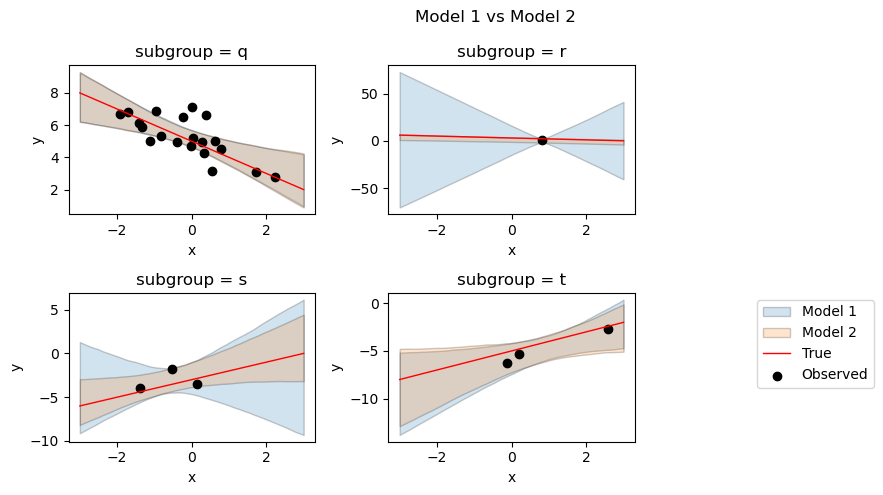

In [39]:
compare_models(1,2)

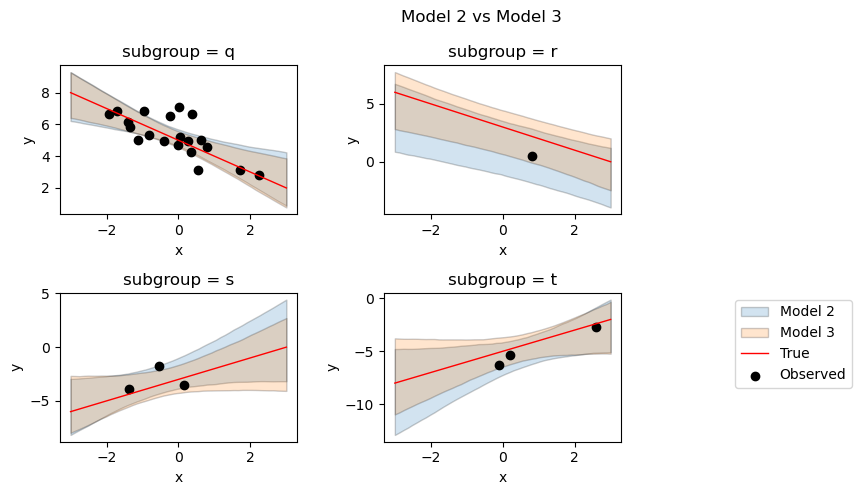

In [40]:
compare_models(2,3)

We see that with this data, each added complexity brings estimates closer to the true regression lines. However, the improvement is more noticable among the subgroups with few observations, especially subgroup r. For subgroup q, we can barely see any change at all.

## Summary
Despite the increased complexity, coding the three different models are almost equally simple in Sakkara. Instead, the development may instead be focused to make the dataframe into a Sakkara-friendly format.

